In [7]:
import os
import datetime
import torch
import IPython
import random
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#os.chdir(os.path.join(os.getcwd(), 'LAS Model'))
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from data import SpeechDataset, AudioDataLoader
from listener import Listener
from attend_and_spell import AttendAndSpell
from seq2seq import Seq2Seq
from utils import  train

import torchaudio
from torchaudio.transforms import MelSpectrogram

### Load Training data

In [2]:
# Used when each sentence is in a separate text file
def make_train_df(dataset_dir):
    data = []
    files = os.listdir(dataset_dir)
    for f in files:
        if '.txt' in f:
            with open(os.path.join(dataset_dir, f), 'r') as text_file:
                data_list = text_file.readlines()
            for example in data_list:
                id_, sent = str(example.split(' ')[0]), str(' '.join(example.split(' ')[1:])) # -1 to remove '\n'
                data.append((id_, sent))

    train_df = pd.DataFrame(data, columns=['id', 'sent'])
    train_df.to_csv(os.path.join(dataset_dir, 'train_df.csv'), header=None)
    return train_df


DEVICE = torch.device('cuda:1') if torch.cuda.is_available() else 'cpu'
print('DEVICE :', DEVICE)

root_dir = '../../../Dataset/common_voice/'
dataset_dir = os.path.join(root_dir, 'clips')

DEVICE : cuda:1


### Dataset Analysis and Cleaning

We need to remove the extra large files from the dataset, cause they may end up filling the CUDA memory and can lead to OOM error.

In [3]:
# Load .tsv files
train_data_df = pd.read_csv(os.path.join(root_dir, 'train.tsv'), delimiter='\t', usecols=['path', 'sentence'])
dev_data_df = pd.read_csv(os.path.join(root_dir, 'dev.tsv'), delimiter='\t', usecols=['path', 'sentence'])
data_df = pd.concat([train_data_df, dev_data_df])

Sentence: In American English, "whilst" is considered to be pretentious or archaic.
Sample rate: 48000
torch.Size([1, 128, 1527])


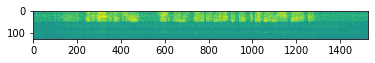

In [23]:
# Analyze one clip
idx = 1
spec = MelSpectrogram()
path, sent = data_df.iloc[idx]
waveform, rate = torchaudio.load(os.path.join(dataset_dir, path))
x = spec(waveform)

print('Sentence:', sent)
print('Sample rate:', rate)
print(x.shape)
IPython.display.Audio(os.path.join(dataset_dir, path))
plt.imshow(x[0,:,:].log2().detach())

In [8]:


audio_len, sent_len = [], []
specgram = MelSpectrogram(sample_rate=48000)

time = datetime.datetime.now()
for idx in range(data_df.shape[0]):
    path, sent = data_df.iloc[idx]
    waveform, rate = torchaudio.load(os.path.join(dataset_dir, path))
    x = specgram(waveform)
    
    audio_len.append(x.shape[2])
    sent_len.append(len(sent))
    if idx == 100:
        break

end_time = datetime.datetime.now()
print(end_time - time)
        
print('Mean time daration (Spectrogram)', np.mean(audio_len))
print('Max size/time (spectrogram)', np.max(audio_len))
print('-'*10)
print('Mean sentence length', np.mean(sent_len))
print('Max sentence length', np.max(sent_len))

0:00:09.958961
Mean time daration (Spectrogram) 1287.2673267326732
Max size/time (spectrogram) 2235
----------
Mean sentence length 58.28712871287129
Max sentence length 110


In [9]:
#import torchaudio
#from torchaudio.transforms import MelSpectrogram

audio_len, sent_len = [], []
specgram_ = MelSpectrogram()

time = datetime.datetime.now()
for idx in range(data_df.shape[0]):
    path, sent = data_df.iloc[idx]
    waveform, rate = torchaudio.load(os.path.join(dataset_dir, path))
    x = specgram_(waveform)
    
    audio_len.append(x.shape[2])
    sent_len.append(len(sent))
    if idx == 100:
        break
        
end_time = datetime.datetime.now()
print(end_time - time)
        
print('Mean time daration (Spectrogram)', np.mean(audio_len))
print('Max size/time (spectrogram)', np.max(audio_len))
print('-'*10)
print('Mean sentence length', np.mean(sent_len))
print('Max sentence length', np.max(sent_len))

0:00:09.912112
Mean time daration (Spectrogram) 1287.2673267326732
Max size/time (spectrogram) 2235
----------
Mean sentence length 58.28712871287129
Max sentence length 110


In [ ]:
# Remove audio/sentences with long duration/length
# Keeping max_duratin = 1500, max_sent_len = 100

data = []
for idx in range(data_df.shape[0]):
    path, sent = data_df.iloc[idx]
    waveform, rate = torchaudio.load(os.path.join(dataset_dir, path+''))
    x = specgram(waveform)
    
    if x.shape[2] > 1500 or len(sent) > 250:
        continue
    else:
        data.append((path, sent))
    if idx%400==0:
        print(len(data))
    
train_df = pd.DataFrame(data, names=['id', 'sent'])
train_df.to_csv(os.path.join(root_dir, 'train_df.csv'), header=None) # save

../../../Dataset/common_voice/clips/common_voice_en_18885784.mp3


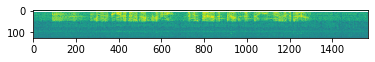

In [24]:
import matplotlib.pyplot as plt

idx = 0
path, sent = data_df.iloc[idx]
specgram = MelSpectrogram()
waveform, rate = torchaudio.load(os.path.join(dataset_dir, path+''))
print(os.path.join(dataset_dir, path+''))
x = specgram(waveform)

plt.imshow(x[0,:,:].log2().detach())

Load the saved csv file.

In [ ]:
train_df = pd.read_csv(os.path.join(root_dir, 'train_df.csv'), names=['id', 'sent'])
train_df = train_df.dropna(how='any')

print("Num training examples", train_df.shape[0])
print(train_df.head())

### DataLoaders and hyperparams

In [15]:
def get_chars(lang, include_digits=True):
    if include_digits:
        chars = ['<sos>', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', \
                 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', \
                'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', \
                 'x', 'y', 'z', ' ', "'", '<eos>', '<pad>', '<unk>']
    else:
        chars = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', \
                'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', \
                'y', 'z', ' ', "'", '<eos>', '<pad>', '<unk>']
    print('Number of chars', len(chars))
    return chars


chars = get_chars(include_digits=True)
char_to_token = {c:i for i,c in enumerate(chars)} 
token_to_char = {i:c for c,i in char_to_token.items()}
sos_token = char_to_token['<sos>']
eos_token = char_to_token['<eos>']
pad_token = char_to_token['<pad>']

#---------------------reasons for leakage, any one of these two--------------_____#

tensorboard_dir = os.path.join('tb_summary')
train_dataset = SpeechDataset(train_df, dataset_dir, sos_token, char_to_token, eos_token, 
                              device=DEVICE, file_extension='.flac')
train_loader = AudioDataLoader(pad_token, train_dataset, batch_size=32, shuffle=True, drop_last=True)


Number of chars 31


### Instantiate model

In [ ]:
if load:
    saved_file = 'Trained Models/Training_2019-12-25 00:09:23.921978/las_model_6'
    model.load_state_dict(torch.load(saved_file))
    start_epoch = int(saved_file[-1]) + 1
    time = os.listdir(tensorboard_dir)[-1]  # use the last one
else:
    start_epoch = 0
    time = str(datetime.datetime.now())

save_dir = os.path.join('Trained_models', f'Training_{time}')
try:    
    os.mkdir(save_dir);
except FileExistsError:
    pass

In [4]:
input_size = 128    # num rows in instagram
hidden_dim = 64  # 256*2 nodes in each LSTM
num_layers = 3
dropout = 0.1
layer_norm = False   
encoder = Listener(input_size, hidden_dim, num_layers, dropout=dropout, layer_norm=layer_norm)

hid_sz = 64
embed_dim = 30
vocab_size = len(chars)
decoder = AttendAndSpell(embed_dim, hid_sz, encoder.output_size, vocab_size)

hyperparams = {'input_size':input_size, 'hidden_dim':hidden_dim, 'num_layers':num_layers,
                'dropout':dropout, 'layer_norm':layer_norm, 'hid_sz':hid_sz, 'embed_dim':embed_dim}

criterion = nn.CrossEntropyLoss()
model = Seq2Seq(encoder, decoder, criterion, tf_ratio = 1.0, device=DEVICE).to(DEVICE)

### Training

In [ ]:
optimizer = optim.ASGD(model.parameters(), lr=0.2)  # lr = 0.2 used in paper
# optimizer = optim.Adadelta(model.parameters())
scheduler = optim.lr_scheduler.Ste
pLR(optimizer, step_size=1, gamma=0.98)
log_interval = 5
print_interval = 40

epochs = 20
load = False

summary_dir = os.path.join(tensorboard_dir, time)
writer = SummaryWriter(summary_dir)

# Saving hyperparmas
with open(os.path.join(save_dir, 'info.txt'), 'wb') as f:
    pickle.dump(hyperparams, f)

for epoch in range(start_epoch, epochs):
    print("\nTeacher forcing ratio:", model.tf_ratio)
    train(model, DEVICE, train_loader, optimizer, epoch, print_interval, writer, log_interval)
    scheduler.step()                                    # Decrease learning rate
    torch.save(model.state_dict(), os.path.join(save_dir, f'las_model_{epoch}'))
    model.tf_ratio = max(model.tf_ratio - 0.05, 0.8)    # Decrease teacher force ratio


Teacher forcing ratio: 1.0
Training, Logging: Mean loss of previous 40 batches 

Train Epoch: 0 [1248/104014 (1%)]	Mean Loss : 27.969870	 time 0:01:18.568658:
Train Epoch: 0 [2528/104014 (2%)]	Mean Loss : 27.677372	 time 0:01:14.936303:
Train Epoch: 0 [3808/104014 (4%)]	Mean Loss : 27.855455	 time 0:01:16.635070:
Train Epoch: 0 [5088/104014 (5%)]	Mean Loss : 27.662129	 time 0:01:14.736184:
Train Epoch: 0 [6368/104014 (6%)]	Mean Loss : 28.179919	 time 0:01:16.618391:
Train Epoch: 0 [7648/104014 (7%)]	Mean Loss : 27.585653	 time 0:01:16.532999:
Train Epoch: 0 [8928/104014 (9%)]	Mean Loss : 28.274216	 time 0:01:16.849946:
Train Epoch: 0 [10208/104014 (10%)]	Mean Loss : 27.828933	 time 0:01:15.798461:
Train Epoch: 0 [11488/104014 (11%)]	Mean Loss : 27.300104	 time 0:01:14.339550:
Train Epoch: 0 [12768/104014 (12%)]	Mean Loss : 27.592005	 time 0:01:14.699517:
Train Epoch: 0 [14048/104014 (14%)]	Mean Loss : 27.593386	 time 0:01:15.094730:
Train Epoch: 0 [15328/104014 (15%)]	Mean Loss : 27.3

### TEST

In [6]:
def decode_pred_sent(out):
    pred_sent = []
    for t in out:
        lol = t.max(dim=1)[1].item()
        pred_sent.append(token_to_char[lol])
    return ''.join(pred_sent)


def decode_true_sent(y):
    sent = []
    for t in y:
        sent.append(token_to_char[t.item()])
    return ''.join(sent)

In [9]:
DEVICE = torch.device('cpu')

In [13]:
num_sent = 10
model.eval()
model.to(DEVICE)
model.device = DEVICE
model.tf_ratio = 0.9

for _ in range(num_sent):
    
    idx = random.randint(0, train_df.shape[0])
    trial_dataset = SpeechDataset(train_df, dataset_dir, sos_token, char_to_token, eos_token, file_extension='.flac')

    x, y = trial_dataset.__getitem__(idx)
    # plt.imshow(x[0,:,:].detach())

    # Model output
    target = y.unsqueeze(dim=0).to(DEVICE)
    data = x.permute(0, 2, 1).to(DEVICE)
    loss, output = model(data, target)
    print("True sent : ", decode_true_sent(y), end='\n\n')
    print("Pred sent : ", decode_pred_sent(output))
    print("Loss :", loss.item())    
    print("\n")

True sent :  <sos>who was now approaching womanhood he would sometimes talk with her differently from the manner in which he would speak to a mere girl but on her part she seemed not to notice the difference and for their daily amusement either go<eos>

Pred sent :   uholshs sornsnpropsh ng shmpndsun sorshuld shmp hnpl shll shlh hor shgfordds f soom shv sord r sn sholl sorshmld shrrssh nsnd r dsorlpsurosf sor srrshsho shnnud sor shvsor sorshvososfordd krsnd sor shv r sonnh snosh ond sngh<eos>r soo
Loss : 722.2744140625


True sent :  <sos>now sworn to the service of his most christian majesty<eos>

Pred sent :   uor shordssh shj shnoongdshosos sors soooshgnn soruss  
Loss : 178.7652587890625


True sent :  <sos>and a paper cap on his head has the strong conscience and the strong sense the blended susceptibility and self command of our friend adam he was not an average man yet such men as he are reared here and there in every generation of our peasant artisans<eos>

Pred sent :   und sh